In [59]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import segmentation_models as sm


new_image_dir = "/Users/anandhu/Downloads/Final Project/Flood Test" 
output_mask_dir = "./predicted_masks"
output_overlay_dir = "./overlay_images"

os.makedirs(output_mask_dir, exist_ok=True)
os.makedirs(output_overlay_dir, exist_ok=True)


def iou_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)


model = load_model(
    "unet_finetuned_best.h5",
    custom_objects={
        "iou_metric": iou_metric,
        "dice_metric": dice_metric,
        "binary_crossentropy_plus_dice_loss": sm.losses.bce_dice_loss
    }
)


flood_coverages = []

for filename in sorted(os.listdir(new_image_dir)):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(new_image_dir, filename)

        # Preprocess: resize & normalize
        img = Image.open(path).convert("RGB").resize((256, 256))
        arr = np.array(img, dtype=np.float32) / 255.0
        input_tensor = np.expand_dims(arr, axis=0)

        # Predict mask
        prediction = model.predict(input_tensor)[0]
        mask = (prediction > 0.5).astype(np.uint8).squeeze()

        # Save predicted binary mask
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))
        mask_img.save(os.path.join(output_mask_dir, f"{filename.split('.')[0]}_mask.png"))

        # Save overlay visualization
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.imshow(mask, cmap="jet", alpha=0.4)
        plt.axis("off")
        plt.savefig(os.path.join(output_overlay_dir, f"{filename.split('.')[0]}_overlay.png"),
                    bbox_inches='tight', pad_inches=0)
        plt.close()

        # Calculate and store flood area %
        flood_percent = np.mean(mask) * 100
        flood_coverages.append(flood_percent)

        print(f" {filename} → Flood coverage: {flood_percent:.2f}%")


print("\n GENERALIZATION SUMMARY (No Ground Truth):")
print(f" Average Predicted Flood Area: {np.mean(flood_coverages):.2f}%")
print(f" Minimum Predicted: {np.min(flood_coverages):.2f}%")
print(f" Maximum Predicted: {np.max(flood_coverages):.2f}%")
print(f" Overlay images saved in: {output_overlay_dir}")
print(f" Binary masks saved in: {output_mask_dir}")

1/1 [==============================] - 0s 131ms/step
 1.png → Flood coverage: 7.63%
1/1 [==============================] - 0s 35ms/step
 2.png → Flood coverage: 6.85%
1/1 [==============================] - 0s 40ms/step
 3.png → Flood coverage: 8.98%
1/1 [==============================] - 0s 38ms/step
 4.png → Flood coverage: 3.85%
1/1 [==============================] - 0s 37ms/step
 5.png → Flood coverage: 8.95%
1/1 [==============================] - 0s 37ms/step
 6.png → Flood coverage: 6.81%
1/1 [==============================] - 0s 38ms/step
 7.png → Flood coverage: 9.61%

 GENERALIZATION SUMMARY (No Ground Truth):
 Average Predicted Flood Area: 7.53%
 Minimum Predicted: 3.85%
 Maximum Predicted: 9.61%
 Overlay images saved in: ./overlay_images
 Binary masks saved in: ./predicted_masks


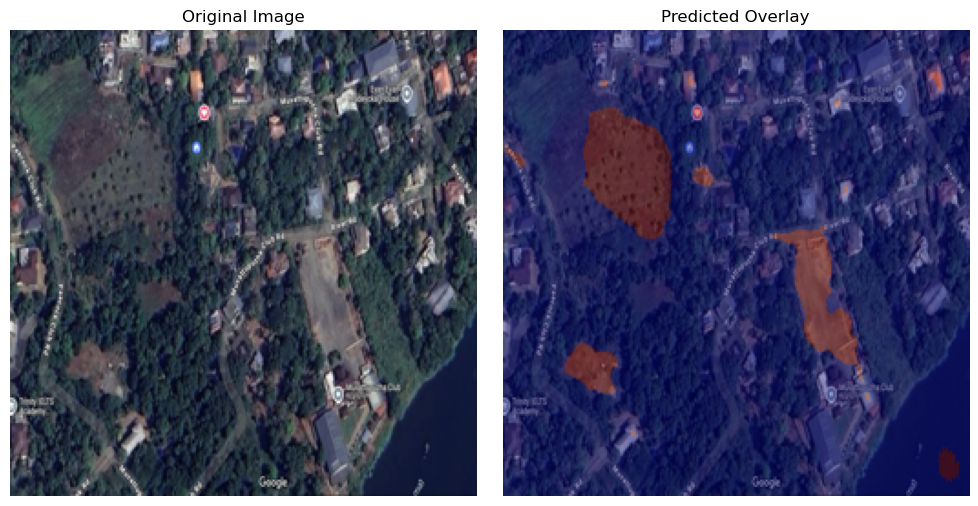

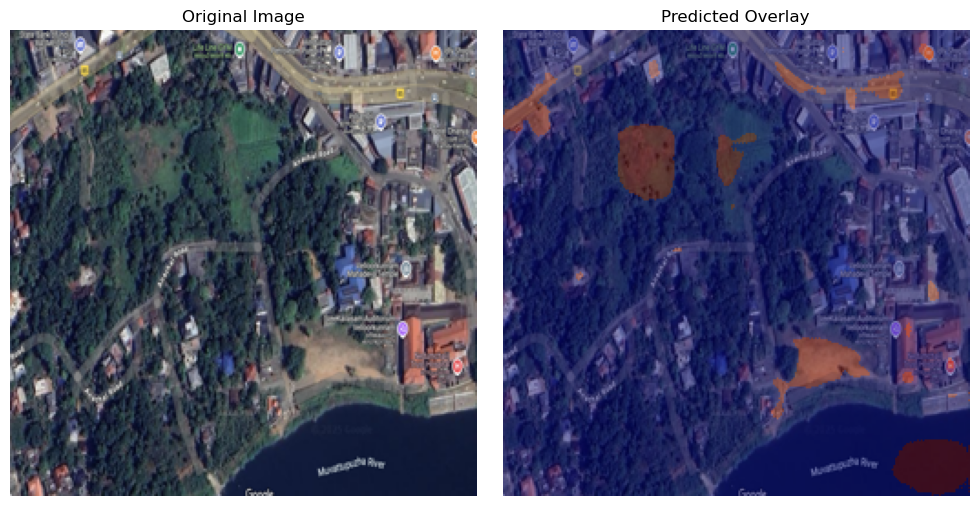

In [61]:
# -----------------------------
#  VISUALIZE SAMPLE PREDICTIONS
# -----------------------------
import matplotlib.pyplot as plt

# Choose 2 sample files to display
sample_files = sorted(os.listdir(output_mask_dir))[:2]

for file in sample_files:
    # Load original image
    base_name = file.replace("_mask.png", "")
    image_path = os.path.join(new_image_dir, base_name + ".png")  
    if not os.path.exists(image_path):
        image_path = os.path.join(new_image_dir, base_name + ".jpg")
    if not os.path.exists(image_path):
        continue  # skip if no matching original image

    original = Image.open(image_path).convert("RGB").resize((256, 256))

    # Load predicted mask
    mask = Image.open(os.path.join(output_mask_dir, file))

    # Display side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(original)
    plt.imshow(mask, cmap="jet", alpha=0.4)
    plt.title("Predicted Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [63]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import segmentation_models as sm
import cv2


new_image_dir = "/Users/anandhu/Downloads/Final Project/Flood Test"
output_mask_dir = "./predicted_masks"
output_overlay_dir = "./overlay_images"
pseudo_mask_dir = "./pseudo_ground_truth_masks"

os.makedirs(output_mask_dir, exist_ok=True)
os.makedirs(output_overlay_dir, exist_ok=True)
os.makedirs(pseudo_mask_dir, exist_ok=True)

# === Metrics ===
def iou_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_metric(y_true, y_pred, smooth=1):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# === Load model ===
model = load_model(
    "unet_finetuned_best.h5",
    custom_objects={
        "iou_metric": iou_metric,
        "dice_metric": dice_metric,
        "binary_crossentropy_plus_dice_loss": sm.losses.bce_dice_loss
    }
)

flood_coverages = []

# === Prediction + Overlay + Pseudo mask generation ===
for filename in sorted(os.listdir(new_image_dir)):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(new_image_dir, filename)

        # Preprocess image
        img = Image.open(path).convert("RGB").resize((256, 256))
        arr = np.array(img, dtype=np.float32) / 255.0
        input_tensor = np.expand_dims(arr, axis=0)

        # Predict
        prediction = model.predict(input_tensor)[0]
        mask = (prediction > 0.5).astype(np.uint8).squeeze()

        # Save predicted mask
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))
        mask_img.save(os.path.join(output_mask_dir, f"{filename.split('.')[0]}_mask.png"))

        # Save overlay
        overlay_path = os.path.join(output_overlay_dir, f"{filename.split('.')[0]}_overlay.png")
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.imshow(mask, cmap="jet", alpha=0.4)
        plt.axis("off")
        plt.savefig(overlay_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Flood % coverage
        flood_percent = np.mean(mask) * 100
        flood_coverages.append(flood_percent)
        print(f" {filename} → Flood coverage: {flood_percent:.2f}%")

        
        try:
            overlay = cv2.imread(overlay_path)
            overlay = cv2.resize(overlay, (256, 256))
            hsv = cv2.cvtColor(overlay, cv2.COLOR_BGR2HSV)

            # Red color detection
            lower_red1 = np.array([0, 70, 50])
            upper_red1 = np.array([10, 255, 255])
            lower_red2 = np.array([160, 70, 50])
            upper_red2 = np.array([180, 255, 255])

            mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
            mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
            full_mask = cv2.bitwise_or(mask1, mask2)
            binary_mask = (full_mask > 0).astype(np.uint8) * 255

            output_pseudo_path = os.path.join(pseudo_mask_dir, f"{filename.split('.')[0]}_pseudo_mask.png")
            cv2.imwrite(output_pseudo_path, binary_mask)
            print(f" Pseudo mask saved: {output_pseudo_path}")
        except Exception as e:
            print(f" Failed to create pseudo mask for {filename}: {e}")

# === Summary ===
print("\n GENERALIZATION SUMMARY (No Ground Truth):")
print(f" Average Predicted Flood Area: {np.mean(flood_coverages):.2f}%")
print(f" Minimum Predicted: {np.min(flood_coverages):.2f}%")
print(f" Maximum Predicted: {np.max(flood_coverages):.2f}%")
print(f"\n Overlay images saved in: {output_overlay_dir}")
print(f" Binary masks saved in: {output_mask_dir}")
print(f" Pseudo ground truth masks saved in: {pseudo_mask_dir}")

1/1 [==============================] - 0s 79ms/step
 1.png → Flood coverage: 7.63%
 Pseudo mask saved: ./pseudo_ground_truth_masks/1_pseudo_mask.png
1/1 [==============================] - 0s 35ms/step
 2.png → Flood coverage: 6.85%
 Pseudo mask saved: ./pseudo_ground_truth_masks/2_pseudo_mask.png
1/1 [==============================] - 0s 34ms/step
 3.png → Flood coverage: 8.98%
 Pseudo mask saved: ./pseudo_ground_truth_masks/3_pseudo_mask.png
1/1 [==============================] - 0s 35ms/step
 4.png → Flood coverage: 3.85%
 Pseudo mask saved: ./pseudo_ground_truth_masks/4_pseudo_mask.png
1/1 [==============================] - 0s 36ms/step
 5.png → Flood coverage: 8.95%
 Pseudo mask saved: ./pseudo_ground_truth_masks/5_pseudo_mask.png
1/1 [==============================] - 0s 35ms/step
 6.png → Flood coverage: 6.81%
 Pseudo mask saved: ./pseudo_ground_truth_masks/6_pseudo_mask.png
1/1 [==============================] - 0s 34ms/step
 7.png → Flood coverage: 9.61%
 Pseudo mask saved: ./p

In [57]:
from sklearn.metrics import accuracy_score


from tensorflow.keras.backend import constant as Kconst

print("\n Evaluating predicted masks against Model-Derived Masks  ground truth...\n")

eval_accuracies = []
eval_ious = []
eval_dices = []

for file in os.listdir(output_mask_dir):
    if file.endswith("_mask.png"):
        pred_path = os.path.join(output_mask_dir, file)
        pseudo_path = os.path.join(pseudo_mask_dir, file.replace("_mask.png", "_pseudo_mask.png"))

        if not os.path.exists(pseudo_path):
            print(f" Pseudo mask not found for {file}, skipping.")
            continue

        pred = Image.open(pred_path).convert("L").resize((256, 256))
        pred_bin = (np.array(pred) > 127).astype(np.uint8)

        pseudo = Image.open(pseudo_path).convert("L").resize((256, 256))
        pseudo_bin = (np.array(pseudo) > 127).astype(np.uint8)

        acc = accuracy_score(pseudo_bin.flatten(), pred_bin.flatten())
        iou = iou_metric(Kconst(pseudo_bin), Kconst(pred_bin)).numpy()
        dice = dice_metric(Kconst(pseudo_bin), Kconst(pred_bin)).numpy()

        eval_accuracies.append(acc)
        eval_ious.append(iou)
        eval_dices.append(dice)

        print(f" {file}: Acc={acc:.4f}, IoU={iou:.4f}, Dice={dice:.4f}")


print("\nModel-Derived Masks SUMMARY:")
print(f" Average Accuracy: {np.mean(eval_accuracies):.4f}")
print(f" Average IoU     : {np.mean(eval_ious):.4f}")
print(f" Average Dice    : {np.mean(eval_dices):.4f}")


 Evaluating predicted masks against Model-Derived Masks  ground truth...

 4_mask.png: Acc=0.9985, IoU=0.9607, Dice=0.9799
 5_mask.png: Acc=0.9980, IoU=0.9777, Dice=0.9887
 3_mask.png: Acc=0.9966, IoU=0.9631, Dice=0.9812
 2_mask.png: Acc=0.9961, IoU=0.9436, Dice=0.9710
 7_mask.png: Acc=0.9969, IoU=0.9683, Dice=0.9839
 6_mask.png: Acc=0.9987, IoU=0.9806, Dice=0.9902
 1_mask.png: Acc=0.9978, IoU=0.9719, Dice=0.9858

Model-Derived Masks SUMMARY:
 Average Accuracy: 0.9975
 Average IoU     : 0.9666
 Average Dice    : 0.9830
